In [1]:
## IMPORTS
import importlib
import os
from pathlib import Path
import time

import ipywidgets as widgets
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import IPython 
import lib.utils as _utils
import lib.atus_tools as att
from lib.utils import get_project_logger, config_project_logger, \
    SUCCESS, rotate_ax_labels, get_color_cycle_list, get_x_array_for_barplots

# -------------
_LOGGER = get_project_logger().getChild("ipynb")
# importlib.reload(att)


# %matplotlib widget
# mpl.rcParams["pdf.fonttype"] = 42  # Make text editable in exported pdfs


[atus] DEBUG: `rtrend` Logger configured.


In [2]:
# PARAMETERS
# =========================================

# Preprocessing directory path
# ----------------------------
# --- Baseline 
# preproc_dir = Path("outputs/baseline/by_occupation/")
# preproc_dir = Path("outputs/baseline/by_industry/")
preproc_dir = Path("outputs/baseline/with_bootstrap_100/")

# --- Alternative/sensitivity
# preproc_dir = Path("outputs/alternative/income_classes_20-80_occ/")
# preproc_dir = Path("outputs/alternative/income_classes_20-80_ind/")

# --- Devtests
# preproc_dir = Path("outputs/tests/preproc_dev/")
## comment test
# Mosquito diel activity
# ----------------------
mosq_count_fname = Path("mosquito_diel_data/mosqdiel_general_counts.csv")

In [3]:
def count_folders(directory):
    # Initialize a counter for folders
    folder_count = 0
    
    # Iterate over each item in the directory
    for item in os.listdir(directory):
        # Check if the item is a folder
        if os.path.isdir(os.path.join(directory, item)):
            # If it's a folder, increment the counter
            folder_count += 1
    
    return folder_count

In [4]:
hourly = False
# preproc_dir, hourly = Path("outputs/tests/main_bootstrap_test/"), False
preproc_dir, hourly = preproc_dir, True


# aggr_features = ["all", "income_id"]
# ------------
aggr_features=[
        "all", "income_id", "TUMONTH", "PESEX", "race_ethnicity", 
        "is_outdoor_job",  "is_weekend", "job_and_weekend", "income_and_weekend","sex_and_weekend","raceth_and_weekend",
#         "occupation_exposure_id",
    ]

# IMPORT PREPROCESSED DATA
# ========================
importlib.reload(att)

# ---

env = att.get_default_atus_env()

# === Load mosquito diel activity
mosq_diel_df = pd.read_csv(mosq_count_fname, index_col=[0, 1])
mosq_diel_df.columns.name = "hour"

mosq_diel_df #hourly mosquito count for different locations

env = att.get_default_atus_env()

# Load original ensemble
main_pre = att.ATUSPreprocBunch.from_dir(
    preproc_dir, aggr_features=aggr_features,
    import_raw=False,
    raise_on_not_found=False,
    tseries_is_hourly=hourly,
    
)

In [6]:
main_pre.feat_hist_df_dict['job_and_weekend']

0         1         2   \
exp_id state_name is_outdoor_job is_weekend                                 
0      Alabama    0              False       0.000000  0.000000  0.000000   
                                 True        0.000000  0.000000  0.000000   
                  1              False       0.000000  0.000000  0.000000   
                                 True        0.000000  0.000000  0.000000   
       Alaska     0              False       0.000000  0.000000  0.000000   
...                                               ...       ...       ...   
2      Wisconsin  1              True        0.604923  0.122728  0.095519   
       Wyoming    0              False       0.519005  0.124379  0.086873   
                                 True        0.541553  0.106936  0.174934   
                  1              False       0.700140  0.299860  0.000000   
                                 True        0.743875  0.256125  0.000000   

                                                   3         4        5   \
exp_id state_name is_outdoor_job is_weekend                                
0      Alabama    0              False       0.000000  0.000000  0.00000   
                                 True        0.000000  0.000000  0.00000   
                  1              False       0.000000  0.000000  0.00000   
                                 True        0.000000  0.000000  0.00000   
       Alaska     0              False       0.000000  0.000000  0.00000   
...                                               ...       ...      ...   
2      Wisconsin  1              True        0.045736  0.021840  0.00000   
       Wyoming    0              False       0.107912  0.023457  0.02308   
                                 True        0.082663  0.010184  0.06286   
                  1              False       0.000000  0.000000  0.00000   
                                 True        0.000000  0.000000  0.00000   

                                                   6         7         8   \
exp_id state_name is_outdoor_job is_weekend                                 
0      Alabama    0              False       0.000000  0.000000  0.000000   
                                 True        0.000000  0.000000  0.000771   
                  1              False       0.000000  0.000000  0.050451   
                                 True        0.000000  0.000000  0.000000   
       Alaska     0              False       0.000000  0.000000  0.000000   
...                                               ...       ...       ...   
2      Wisconsin  1              True        0.000000  0.021616  0.032608   
       Wyoming    0              False       0.009444  0.049788  0.007554   
                                 True        0.020869  0.000000  0.000000   
                  1              False       0.000000  0.000000  0.000000   
                                 True        0.000000  0.000000  0.000000   

                                                   9   ...        15  \
exp_id state_name is_outdoor_job is_weekend            ...             
0      Alabama    0              False       0.000000  ...  0.031623   
                                 True        0.007753  ...  0.014694   
                  1              False       0.000000  ...  0.124724   
                                 True        0.000000  ...  0.000000   
       Alaska     0              False       0.020645  ...  0.082892   
...                                               ...  ...       ...   
2      Wisconsin  1              True        0.000000  ...  0.000000   
       Wyoming    0              False       0.027794  ...  0.000000   
                                 True        0.000000  ...  0.000000   
                  1              False       0.000000  ...  0.000000   
                                 True        0.000000  ...  0.000000   

                                                   16        17        18  \
exp_id state_name is_outdoor_job is_weekend 

In [7]:
# === Create ATUS environment
fname = main_pre.meta_dict.get("atus_environment_path", None)
if fname is not None:
    myenv = att.ATUSEnvironment.from_env_file(fname)
else:
    _LOGGER.warn("No ATUS env path in metadata. Will create default environment.")
    myenv = att.get_default_atus_env()
    
# === Load state metadata
fips_df = att.import_fips_df(main_pre.meta_dict["fips_fname"])

# ---
main_pre.meta_dict["use_aggr_features"]

['all',
 'PESEX',
 'TUMONTH',
 'is_weekend',
 'race_ethnicity',
 'income_id',
 'occupation_exposure_id',
 'is_outdoor_job',
 {'job_and_weekend': ['is_outdoor_job', 'is_weekend']},
 {'income_and_weekend': ['income_id', 'is_weekend']},
 {'raceth_and_weekend': ['race_ethnicity', 'is_weekend']},
 {'sex_and_weekend': ['PESEX', 'is_weekend']}]

In [9]:
boot_pre_list[2].feat_aggr_df_dict['sex_and_weekend']

2023-01-01 00:00:00  2023-01-01 01:00:00  \
exp_id state_name PESEX is_weekend                                             
0      Alabama    1     False                  0.971848             0.986565   
                        True                   0.993855             0.993855   
                  2     False                  0.992494             0.996607   
                        True                   0.993135             0.999112   
       Alaska     1     False                  1.000000             0.992291   
...                                                 ...                  ...   
2      Wisconsin  2     True                   0.020831             0.005269   
       Wyoming    1     False                  0.000000             0.000000   
                        True                   0.000000             0.000000   
                  2     False                  0.062263             0.020754   
                        True                   0.000000             0.000000   

                                    2023-01-01 02:00:00  2023-01-01 03:00:00  \
exp_id state_name PESEX is_weekend                                             
0      Alabama    1     False                  0.976722             0.971122   
                        True                   0.991187             0.977463   
                  2     False                  0.996607             0.997376   
                        True                   0.999511             0.998899   
       Alaska     1     False                  1.000000             1.000000   
...                                                 ...                  ...   
2      Wisconsin  2     True                   0.016814             0.015939   
       Wyoming    1     False                  0.000000             0.000000   
                        True                   0.000000             0.000000   
                  2     False                  0.000000             0.000000   
                        True                   0.000000             0.000000   

                                    2023-01-01 04:00:00  2023-01-01 05:00:00  \
exp_id state_name PESEX is_weekend                                             
0      Alabama    1     False                  0.928572             0.901548   
                        True                   0.965069             0.947250   
                  2     False                  0.996607             0.981850   
                        True                   1.000000             0.998774   
       Alaska     1     False                  0.984552             0.972166   
...                                                 ...                  ...   
2      Wisconsin  2     True                   0.003112             0.007614   
       Wyoming    1     False                  0.021559             0.029491   
                        True                   0.000000             0.000000   
                  2     False                  0.000000             0.000702   
                        True                   0.000000             0.000000   

                                    2023-01-01 06:00:00  2023-01-01 07:00:00  \
exp_id state_name PESEX is_weekend                                             
0      Alabama    1     False                  0.796411             0.686975   
                        True                   0.908173             0.882540   
                  2     False                  0.967188             0.938004   
                        True                   0.982127             0.953136   
       Alaska     1     False                  0.980423             0.937744   
...                                                 ...                  ...   
2      Wisconsin  2     True                   0.034311             0.044793   
       Wyoming    1     False                  0.088921             0.155184   
                        True                   0.000000             0.000000   
                  2     False    

In [11]:
## concating all bootstrap data into multiindex

boot_df = pd.concat(
    [boot_pre_list[i].feat_aggr_df_dict["all"] for i in samples],
    axis=0,
    keys=samples,
    names=["i_boot"],
)

boot_df

2023-01-01 00:00:00  2023-01-01 01:00:00  \
i_boot exp_id state_name    all                                              
0      0      Alabama       True             0.992003             0.994709   
              Alaska        True             1.000000             0.996233   
              Arizona       True             0.980498             0.984619   
              Arkansas      True             0.983057             0.990840   
              California    True             0.980852             0.986388   
...                                               ...                  ...   
99     2      Virginia      True             0.020948             0.019635   
              Washington    True             0.014276             0.011419   
              West Virginia True             0.028590             0.010801   
              Wisconsin     True             0.024790             0.019661   
              Wyoming       True             0.016121             0.005374   

                                  2023-01-01 02:00:00  2023-01-01 03:00:00  \
i_boot exp_id state_name    all                                              
0      0      Alabama       True             0.994570             0.991746   
              Alaska        True             1.000000             1.000000   
              Arizona       True             0.985288             0.983310   
              Arkansas      True             0.997904             0.997259   
              California    True             0.990805             0.989254   
...                                               ...                  ...   
99     2      Virginia      True             0.015993             0.011331   
              Washington    True             0.009219             0.007146   
              West Virginia True             0.010796             0.006759   
              Wisconsin     True             0.013481             0.012551   
              Wyoming       True             0.000000             0.018815   

                                  2023-01-01 04:00:00  2023-01-01 05:00:00  \
i_boot exp_id state_name    all                                              
0      0      Alabama       True             0.982672             0.966464   
              Alaska        True             0.976880             0.970829   
              Arizona       True             0.980919             0.961787   
              Arkansas      True             0.987528             0.971772   
              California    True             0.984261             0.961268   
...                                               ...                  ...   
99     2      Virginia      True             0.021152             0.028394   
              Washington    True             0.007063             0.018124   
              West Virginia True             0.020064             0.029429   
              Wisconsin     True             0.013427             0.025224   
              Wyoming       True             0.010311             0.038351   

                                  2023-01-01 06:00:00  2023-01-01 07:00:00  \
i_boot exp_id state_name    all                                              
0      0      Alabama       True             0.935649             0.890246   
              Alaska        True             0.972638             0.940053   
              Arizona       True             0.921470             0.881676   
              Arkansas      True             0.926141             0.854593   
              California    True             0.917096             0.858182   
...                                               ...                  ...   
99     2      Virginia      True             0.037860             0.079013   
              Washington    True             0.048375             0.085822   
              West Virginia True             0.064094             0.090319   
              Wisconsin     True             0.067994             0.119721   
              Wyoming       True             0.070446

In [26]:
def count_folders(directory):
    # Initialize a counter for folders
    folder_count = 0
    
    # Iterate over each item in the directory
    for item in os.listdir(directory):
        # Check if the item is a folder
        if os.path.isdir(os.path.join(directory, item)):
            # If it's a folder, increment the counter
            folder_count += 1
    
    return folder_count


def create_folder_if_not_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' created successfully.")
    else:
        print(f"Folder '{folder_path}' already exists.")

Folder 'tmp_figs/preprint' already exists.


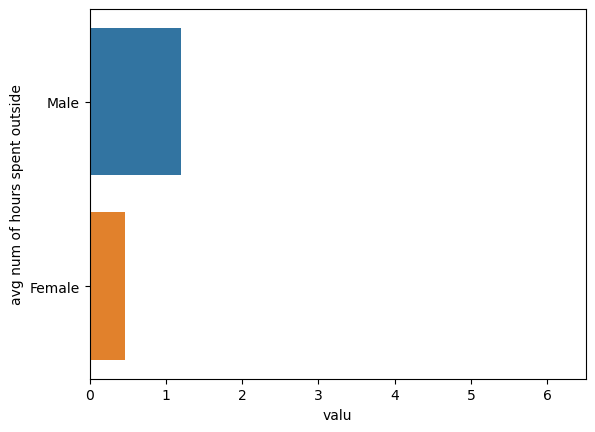

In [54]:
# ====================================
# SELECTABLE FEATURE – Time series
# ====================================
exp_id = 1  # Outdoor only

# feat_name, id_to_name = "income_id", lambda x: env.income_id_to_name[x]
feat_name, id_to_name = "PESEX", lambda x: env.pesex_to_name[x]
# feat_name, id_to_name = "race_ethnicity", lambda x: env.race_id_to_name[x]
# # feat_name, id_to_name = "occupation_exposure_id", lambda x: f"{env.actype_id_to_name[x]} job"
# feat_name, id_to_name = "all", lambda x: "Everyone" if x else "No-one [:"
# feat_name, id_to_name = "is_outdoor_job", lambda x: "Outdoor job" if x else "Indoor/mixed job"
# feat_name, id_to_name = "is_weekend", lambda x: "Weekends" if x else "Weekdays"
# --- Composite features
# feat_name, id_to_name = "job_and_weekend", lambda x: f"{'outdoor' if x[0] else 'indoor'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "income_and_weekend", lambda x: f"{env.income_id_to_name[x[0]]} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x==1 else 'female'}"
# feat_name, id_to_name = "raceth_and_weekend", lambda x: f"{env.race_id_to_name[x]}"

main_df = main_pre.feat_aggr_df_dict[feat_name]
if hourly:
    main_df.columns.name = "hour"
else:
    main_df = att.aggregate_exp_minutes_to_hours(df)

main_df_wted = att.aggregate_states_series_with_weights(
    main_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)

boot_df = pd.concat(
    [boot_pre_list[i].feat_aggr_df_dict[feat_name] for i in samples],
    axis=0,
    keys=samples,
    names=["i_boot"],
)

if hourly:
    boot_df.columns.name = "hour"
else:
    boot_df = att.aggregate_exp_minutes_to_hours(df)

boot_df_wted = att.aggregate_states_series_with_weights(
    boot_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")
boot_df_mean=boot_df_grp.groupby([feat_name]).mean().T.sum().to_frame().unstack()

bootstraped=boot_df_grp.T.sum().to_frame()
bootstraped.rename(columns={0:'valu'},inplace=True)


df=bootstraped.reset_index()
# mapping={True:'weekend',False:'weekeday'}
# df['weeker']=df['is_weekend'].map(mapping)
df[feat_name]=df[feat_name].map(id_to_name)
# # df['weeker']=df['weeker'].astype('category')
sns.barplot(data=df,y=feat_name,x='valu',estimator=np.mean)
plt.ylabel("avg num of hours spent outside")
# # display(samples_df)
plt.xlim(0, 6.5)

if True:
    create_folder_if_not_exists('tmp_figs/preprint')
    plt.savefig(f"tmp_figs/preprint/{feat_name}.pdf")

In [55]:
print(bootstraped.groupby(feat_name).mean())

print("--------------quantiles-------")
print(bootstraped.groupby(feat_name).quantile(q=0.025))

print(bootstraped.groupby(feat_name).quantile(q=0.975))

           valu
PESEX          
1      1.199617
2      0.465142
--------------quantiles-------
           valu
PESEX          
1      1.160196
2      0.452142
           valu
PESEX          
1      1.235507
2      0.479521


In [18]:
bootstraped

valu
i_boot PESEX          
0      1      1.204750
       2      0.463383
1      1      1.221658
       2      0.475415
2      1      1.175166
...                ...
97     2      0.462230
98     1      1.166683
       2      0.461116
99     1      1.182620
       2      0.456387

[200 rows x 1 columns]

Folder 'tmp_figs/preprint' already exists.


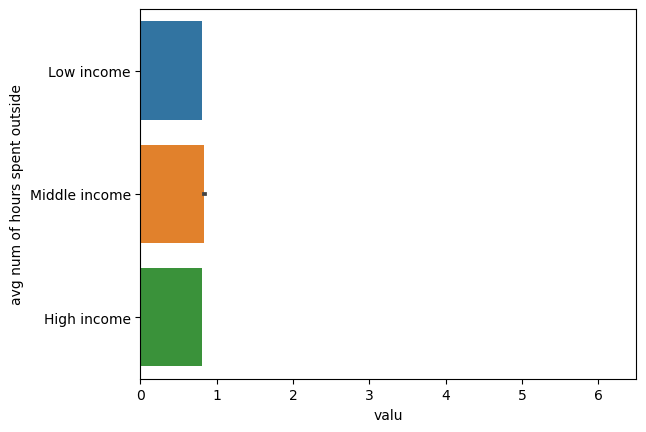

In [57]:
# ====================================
# SELECTABLE FEATURE – Time series
# ====================================
exp_id = 1  # Outdoor only

feat_name, id_to_name = "income_id", lambda x: env.income_id_to_name[x]


main_df = main_pre.feat_aggr_df_dict[feat_name]
if hourly:
    main_df.columns.name = "hour"
else:
    main_df = att.aggregate_exp_minutes_to_hours(df)

main_df_wted = att.aggregate_states_series_with_weights(
    main_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)

boot_df = pd.concat(
    [boot_pre_list[i].feat_aggr_df_dict[feat_name] for i in samples],
    axis=0,
    keys=samples,
    names=["i_boot"],
)

if hourly:
    boot_df.columns.name = "hour"
else:
    boot_df = att.aggregate_exp_minutes_to_hours(df)

boot_df_wted = att.aggregate_states_series_with_weights(
    boot_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")
boot_df_mean=boot_df_grp.groupby([feat_name]).mean().T.sum().to_frame().unstack()

bootstraped=boot_df_grp.T.sum().to_frame()
bootstraped.rename(columns={0:'valu'},inplace=True)


df=bootstraped.reset_index()
# mapping={True:'weekend',False:'weekeday'}
# df['weeker']=df['is_weekend'].map(mapping)
df[feat_name]=df[feat_name].map(id_to_name)
# # df['weeker']=df['weeker'].astype('category')
sns.barplot(data=df,y=feat_name,x='valu',estimator=np.mean)
plt.ylabel("avg num of hours spent outside")
# # display(samples_df)
plt.xlim(0, 6.5)

if True:
    create_folder_if_not_exists('tmp_figs/preprint')
    plt.savefig(f"tmp_figs/preprint/{feat_name}.pdf")

Folder 'tmp_figs/preprint' already exists.


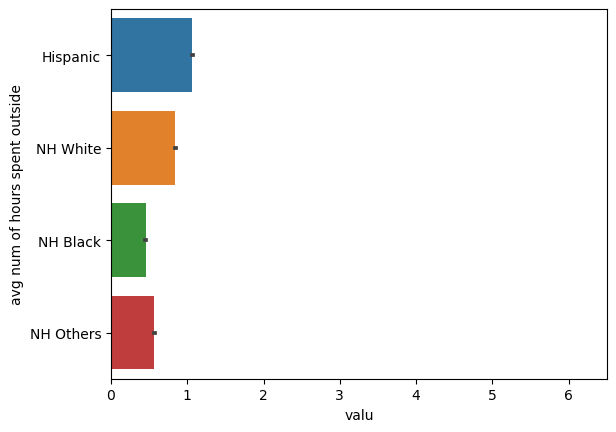

In [49]:
# ====================================
# SELECTABLE FEATURE – Time series
# ====================================
exp_id = 1  # Outdoor only

# feat_name, id_to_name = "income_id", lambda x: env.income_id_to_name[x]
# feat_name, id_to_name = "PESEX", lambda x: env.pesex_to_name[x]
feat_name, id_to_name = "race_ethnicity", lambda x: env.race_id_to_name[x]

main_df = main_pre.feat_aggr_df_dict[feat_name]
if hourly:
    main_df.columns.name = "hour"
else:
    main_df = att.aggregate_exp_minutes_to_hours(df)

main_df_wted = att.aggregate_states_series_with_weights(
    main_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)

boot_df = pd.concat(
    [boot_pre_list[i].feat_aggr_df_dict[feat_name] for i in samples],
    axis=0,
    keys=samples,
    names=["i_boot"],
)

if hourly:
    boot_df.columns.name = "hour"
else:
    boot_df = att.aggregate_exp_minutes_to_hours(df)

boot_df_wted = att.aggregate_states_series_with_weights(
    boot_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")
boot_df_mean=boot_df_grp.groupby([feat_name]).mean().T.sum().to_frame().unstack()

bootstraped=boot_df_grp.T.sum().to_frame()
bootstraped.rename(columns={0:'valu'},inplace=True)


df=bootstraped.reset_index()
# mapping={True:'weekend',False:'weekeday'}
# df['weeker']=df['is_weekend'].map(mapping)
df[feat_name]=df[feat_name].map(id_to_name)
# # df['weeker']=df['weeker'].astype('category')
sns.barplot(data=df,y=feat_name,x='valu',estimator=np.mean)
plt.ylabel("avg num of hours spent outside")
# # display(samples_df)
plt.xlim(0, 6.5)

if True:
    create_folder_if_not_exists('tmp_figs/preprint')
    plt.savefig(f"tmp_figs/preprint/{feat_name}.pdf")

In [53]:
df[feat_name]

0       Hispanic
1       NH White
2       NH Black
3      NH Others
4       Hispanic
         ...    
395    NH Others
396     Hispanic
397     NH White
398     NH Black
399    NH Others
Name: race_ethnicity, Length: 400, dtype: object

In [50]:
print(bootstraped.groupby(feat_name).mean())

print("--------------quantiles-------")
print(bootstraped.groupby(feat_name).quantile(q=0.025))

print(bootstraped.groupby(feat_name).quantile(q=0.975))

                    valu
race_ethnicity          
0               1.066049
1               0.845812
2               0.456330
3               0.570080
--------------quantiles-------
                    valu
race_ethnicity          
0               0.987618
1               0.825511
2               0.416067
3               0.504591
                    valu
race_ethnicity          
0               1.148069
1               0.874346
2               0.502195
3               0.634183


Folder 'tmp_figs/preprint' already exists.


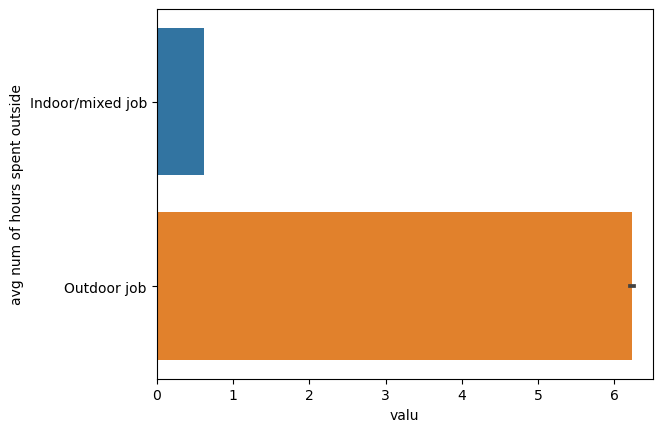

In [40]:
# ====================================
# SELECTABLE FEATURE – Time series
# ====================================
exp_id = 1  # Outdoor only


feat_name, id_to_name = "is_outdoor_job", lambda x: "Outdoor job" if x else "Indoor/mixed job"


main_df = main_pre.feat_aggr_df_dict[feat_name]
if hourly:
    main_df.columns.name = "hour"
else:
    main_df = att.aggregate_exp_minutes_to_hours(df)

main_df_wted = att.aggregate_states_series_with_weights(
    main_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)

boot_df = pd.concat(
    [boot_pre_list[i].feat_aggr_df_dict[feat_name] for i in samples],
    axis=0,
    keys=samples,
    names=["i_boot"],
)

if hourly:
    boot_df.columns.name = "hour"
else:
    boot_df = att.aggregate_exp_minutes_to_hours(df)

boot_df_wted = att.aggregate_states_series_with_weights(
    boot_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")
boot_df_mean=boot_df_grp.groupby([feat_name]).mean().T.sum().to_frame().unstack()

bootstraped=boot_df_grp.T.sum().to_frame()
bootstraped.rename(columns={0:'valu'},inplace=True)


df=bootstraped.reset_index()
# mapping={True:'weekend',False:'weekeday'}
# df['weeker']=df['is_weekend'].map(mapping)
df[feat_name]=df[feat_name].map(id_to_name)
# # df['weeker']=df['weeker'].astype('category')
sns.barplot(data=df,y=feat_name,x='valu',estimator=np.mean)
plt.ylabel("avg num of hours spent outside")
# # display(samples_df)
plt.xlim(0, 6.5)

if True:
    create_folder_if_not_exists('tmp_figs/preprint')
    plt.savefig(f"tmp_figs/preprint/{feat_name}.pdf")

#### race/ethnicity

Text(0, 0.5, 'avg num of hours spent outside')

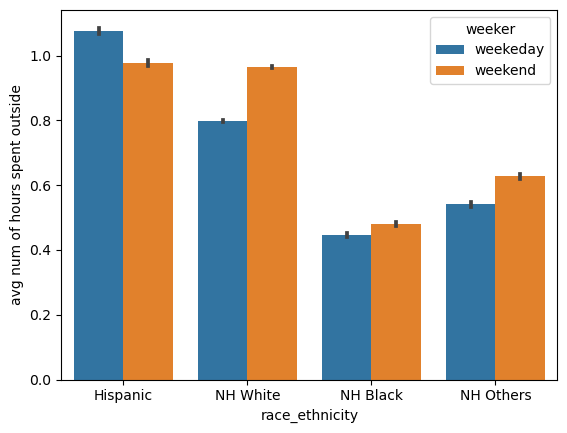

In [13]:
# ====================================
# SELECTABLE FEATURE – Time series
# ====================================
exp_id = 1  # Outdoor only

# feat_name, id_to_name = "income_id", lambda x: env.income_id_to_name[x]
# feat_name, id_to_name = "PESEX", lambda x: env.pesex_to_name[x]
# feat_name, id_to_name = "race_ethnicity", lambda x: env.race_id_to_name[x]
# # feat_name, id_to_name = "occupation_exposure_id", lambda x: f"{env.actype_id_to_name[x]} job"
# feat_name, id_to_name = "all", lambda x: "Everyone" if x else "No-one [:"
# feat_name, id_to_name = "is_outdoor_job", lambda x: "Outdoor job" if x else "Indoor/mixed job"
# feat_name, id_to_name = "is_weekend", lambda x: "Weekends" if x else "Weekdays"
# --- Composite features
# feat_name, id_to_name = "job_and_weekend", lambda x: f"{'outdoor' if x[0] else 'indoor'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "income_and_weekend", lambda x: f"{env.income_id_to_name[x[0]]} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x==1 else 'female'}"
feat_name, id_to_name = "raceth_and_weekend", lambda x: f"{env.race_id_to_name[x]}"

main_df = main_pre.feat_aggr_df_dict[feat_name]
if hourly:
    main_df.columns.name = "hour"
else:
    main_df = att.aggregate_exp_minutes_to_hours(df)

main_df_wted = att.aggregate_states_series_with_weights(
    main_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)

boot_df = pd.concat(
    [boot_pre_list[i].feat_aggr_df_dict[feat_name] for i in samples],
    axis=0,
    keys=samples,
    names=["i_boot"],
)

if hourly:
    boot_df.columns.name = "hour"
else:
    boot_df = att.aggregate_exp_minutes_to_hours(df)

boot_df_wted = att.aggregate_states_series_with_weights(
    boot_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")
boot_df_mean=boot_df_grp.groupby(['race_ethnicity','is_weekend']).mean().T.sum().to_frame().unstack()

bootstraped=boot_df_grp.T.sum().to_frame()
bootstraped.rename(columns={0:'valu'},inplace=True)


df=bootstraped.reset_index()
mapping={True:'weekend',False:'weekeday'}
df['weeker']=df['is_weekend'].map(mapping)
df['race_ethnicity']=df['race_ethnicity'].map(id_to_name)
# df['weeker']=df['weeker'].astype('category')
sns.barplot(data=df,x='race_ethnicity',y='valu',hue='weeker',estimator=np.mean)
plt.ylabel("avg num of hours spent outside")
# display(samples_df)

In [253]:
try1=boot_df_grp.groupby(['race_ethnicity','is_weekend']).mean().T.sum().to_frame()
ndf=try1.reset_index()

In [15]:
boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")
boot_df_mean=boot_df_grp.groupby(['race_ethnicity','is_weekend']).mean().T.sum().to_frame().unstack()
std_err = boot_df_grp.groupby(['race_ethnicity','is_weekend']).sem()

# boot_df_mean.plot(kind='bar',)  # 1.96 is the z-value for 95% confidence interval
# plt.xlabel('Race/Ethnicity')
# plt.ylabel('Value')
# plt.title('Bar Plot with 95% Confidence Intervals')
# plt.legend(title='Is Weekend')

#### income level

Text(0, 0.5, 'avg num of hours spent outside')

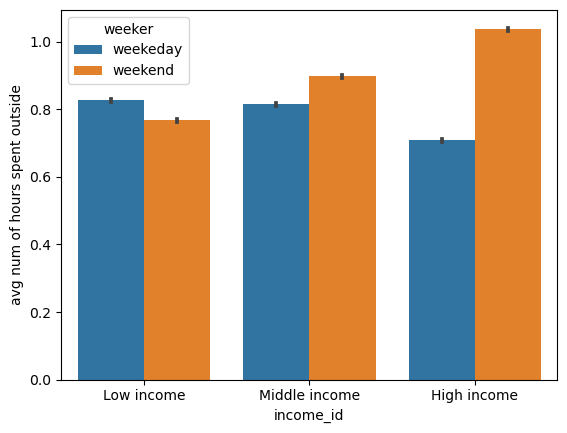

In [14]:
# ====================================
# SELECTABLE FEATURE – Time series
# ====================================
exp_id = 1  # Outdoor only

# feat_name, id_to_name = "income_id", lambda x: env.income_id_to_name[x]
# feat_name, id_to_name = "PESEX", lambda x: env.pesex_to_name[x]
# feat_name, id_to_name = "race_ethnicity", lambda x: env.race_id_to_name[x]
# # feat_name, id_to_name = "occupation_exposure_id", lambda x: f"{env.actype_id_to_name[x]} job"
# feat_name, id_to_name = "all", lambda x: "Everyone" if x else "No-one [:"
# feat_name, id_to_name = "is_outdoor_job", lambda x: "Outdoor job" if x else "Indoor/mixed job"
# feat_name, id_to_name = "is_weekend", lambda x: "Weekends" if x else "Weekdays"
# --- Composite features
# feat_name, id_to_name = "job_and_weekend", lambda x: f"{'outdoor' if x[0] else 'indoor'} {'Weekends' if x[1] else 'Weekdays'}"
feat_name, id_to_name = "income_and_weekend", lambda x: f"{env.income_id_to_name[x]}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x==1 else 'female'}"
# feat_name, id_to_name = "raceth_and_weekend", lambda x: f"{env.race_id_to_name[x]}"

main_df = main_pre.feat_aggr_df_dict[feat_name]
if hourly:
    main_df.columns.name = "hour"
else:
    main_df = att.aggregate_exp_minutes_to_hours(df)

main_df_wted = att.aggregate_states_series_with_weights(
    main_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)

boot_df = pd.concat(
    [boot_pre_list[i].feat_aggr_df_dict[feat_name] for i in samples],
    axis=0,
    keys=samples,
    names=["i_boot"],
)

if hourly:
    boot_df.columns.name = "hour"
else:
    boot_df = att.aggregate_exp_minutes_to_hours(df)

boot_df_wted = att.aggregate_states_series_with_weights(
    boot_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")
boot_df_mean=boot_df_grp.groupby(['income_id','is_weekend']).mean().T.sum().to_frame().unstack()

bootstraped=boot_df_grp.T.sum().to_frame()
bootstraped.rename(columns={0:'valu'},inplace=True)


df=bootstraped.reset_index()
mapping={True:'weekend',False:'weekeday'}
df['weeker']=df['is_weekend'].map(mapping)
df['income_id']=df['income_id'].map(id_to_name)
# df['weeker']=df['weeker'].astype('category')
sns.barplot(data=df,x='income_id',y='valu',hue='weeker',estimator=np.mean)
plt.ylabel("avg num of hours spent outside")
# display(samples_df)

#### gender

Text(0, 0.5, 'avg num of hours spent outside')

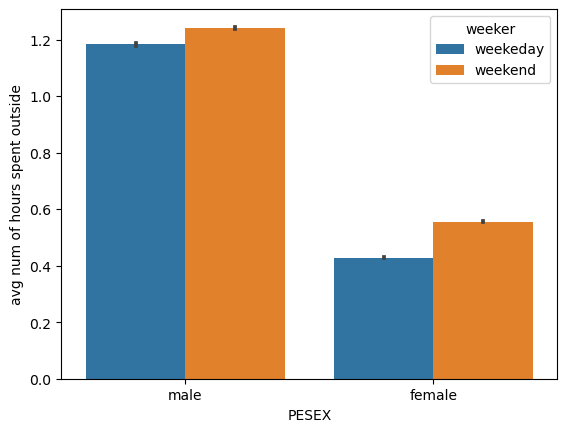

In [21]:
# ====================================
# SELECTABLE FEATURE – Time series
# ====================================
exp_id = 1  # Outdoor only

# feat_name, id_to_name = "income_id", lambda x: env.income_id_to_name[x]
# feat_name, id_to_name = "PESEX", lambda x: env.pesex_to_name[x]
# feat_name, id_to_name = "race_ethnicity", lambda x: env.race_id_to_name[x]
# # feat_name, id_to_name = "occupation_exposure_id", lambda x: f"{env.actype_id_to_name[x]} job"
# feat_name, id_to_name = "all", lambda x: "Everyone" if x else "No-one [:"
# feat_name, id_to_name = "is_outdoor_job", lambda x: "Outdoor job" if x else "Indoor/mixed job"
# feat_name, id_to_name = "is_weekend", lambda x: "Weekends" if x else "Weekdays"
# --- Composite features
# feat_name, id_to_name = "job_and_weekend", lambda x: f"{'outdoor' if x[0] else 'indoor'} {'Weekends' if x[1] else 'Weekdays'}"
# feat_name, id_to_name = "income_and_weekend", lambda x: f"{env.income_id_to_name[x]}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'}"
# feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x[0]==1 else 'female'} {'Weekends' if x[1] else 'Weekdays'}"
feat_name, id_to_name = "sex_and_weekend", lambda x: f"{'male' if x==1 else 'female'}"
# feat_name, id_to_name = "raceth_and_weekend", lambda x: f"{env.race_id_to_name[x]}"

main_df = main_pre.feat_aggr_df_dict[feat_name]
if hourly:
    main_df.columns.name = "hour"
else:
    main_df = att.aggregate_exp_minutes_to_hours(df)

main_df_wted = att.aggregate_states_series_with_weights(
    main_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)

boot_df = pd.concat(
    [boot_pre_list[i].feat_aggr_df_dict[feat_name] for i in samples],
    axis=0,
    keys=samples,
    names=["i_boot"],
)

if hourly:
    boot_df.columns.name = "hour"
else:
    boot_df = att.aggregate_exp_minutes_to_hours(df)

boot_df_wted = att.aggregate_states_series_with_weights(
    boot_df, main_pre.slice_data_df["weight"], 
#     use_level_values=["California", "Florida", "Texas"],
#     use_level_values=["Florida"],
)


boot_df_grp=boot_df_wted.xs(exp_id, level="exp_id")
boot_df_mean=boot_df_grp.groupby(['PESEX','is_weekend']).mean().T.sum().to_frame().unstack()

bootstraped=boot_df_grp.T.sum().to_frame()
bootstraped.rename(columns={0:'valu'},inplace=True)


df=bootstraped.reset_index()
mapping={True:'weekend',False:'weekeday'}
df['weeker']=df['is_weekend'].map(mapping)
df['PESEX']=df['PESEX'].map(id_to_name)
# df['weeker']=df['weeker'].astype('category')
sns.barplot(data=df,x='PESEX',y='valu',hue='weeker',estimator=np.mean)
plt.ylabel("avg num of hours spent outside")
# display(samples_df)

In [22]:
boot_df_grp

hour                     2023-01-01 00:00:00  2023-01-01 01:00:00  \
i_boot PESEX is_weekend                                             
0      1     False                  0.002534             0.001671   
             True                   0.001434             0.001444   
       2     False                  0.000663             0.000602   
             True                   0.001570             0.000966   
1      1     False                  0.002434             0.001894   
...                                      ...                  ...   
98     2     True                   0.001767             0.000539   
99     1     False                  0.002143             0.001533   
             True                   0.002654             0.002346   
       2     False                  0.000808             0.000508   
             True                   0.001937             0.001107   

hour                     2023-01-01 02:00:00  2023-01-01 03:00:00  \
i_boot PESEX is_weekend                                             
0      1     False                  0.002213             0.003136   
             True                   0.001220             0.000982   
       2     False                  0.000635             0.000684   
             True                   0.000420             0.000251   
1      1     False                  0.001624             0.002190   
...                                      ...                  ...   
98     2     True                   0.000542             0.000205   
99     1     False                  0.001299             0.001346   
             True                   0.001728             0.001341   
       2     False                  0.000544             0.000207   
             True                   0.000616             0.000269   

hour                     2023-01-01 04:00:00  2023-01-01 05:00:00  \
i_boot PESEX is_weekend                                             
0      1     False                  0.004594             0.014393   
             True                   0.003109             0.008200   
       2     False                  0.002142             0.004421   
             True                   0.001229             0.003382   
1      1     False                  0.005025             0.015333   
...                                      ...                  ...   
98     2     True                   0.001057             0.002318   
99     1     False                  0.003880             0.014119   
             True                   0.004384             0.009042   
       2     False                  0.001702             0.004848   
             True                   0.001070             0.003048   

hour                     2023-01-01 06:00:00  2023-01-01 07:00:00  \
i_boot PESEX is_weekend                                             
0      1     False                  0.034398             0.063345   
             True                   0.020038             0.045315   
       2     False                  0.013080             0.022202   
             True                   0.008904             0.016491   
1      1     False                  0.036386             0.069128   
...                                      ...                  ...   
98     2     True                   0.007049             0.016408   
99     1     False                  0.036447             0.065375   
             True                   0.023225             0.045540   
       2     False                  0.011559             0.020285   
             True                   0.007575             0.015209   

hour                     2023-01-01 08:00:00  2023-01-01 09:00:00  ...  \
i_boot PESEX is_weekend                                            ...   
0      1     False                  0.087930             0.099042  ...   
             True                   0.073620             0.100136  ...   
       2     False                  0.026678             0.026907  ...   
             True                   0.